In [2]:
%matplotlib inline

In [3]:
from __future__ import division

# Module 8 Lab - Logistic Regression

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [49]:
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
from mpl_toolkits.mplot3d import Axes3D

sns.set(style="darkgrid")

def logm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    y = np.ravel( y) # not sure why this is needed for LogisticRegression but no LinearRegression

    model = linear.LogisticRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    return result

def describe_fit( result):
    formula = result[ "formula"]
    print "regression: ", formula
    print "n: ", result[ "n"]
    print "----------"
    variables = formula.split("~")[1].split( "+")
    variables = ["intercept"] + variables
    coefficients = result[ "coefficients"]
    for variable, coefficient in zip( variables, coefficients):
        print variable.strip() + ": ", coefficient
        
def bootstrap_logm( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = map( lambda x: x.strip(), formula.split("~")[1].split( "+"))
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = data.shape[ 0]
    bootstrap_results[ "n"] = n
    
    for i in xrange( samples):
        sampling_indices = [ i for i in [py_random.randint(0, n - 1) for _ in xrange( 0, n)]]
        sampling = data.loc[ sampling_indices]
        
        results = logm( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)

    bootstrap_results[ "resampled_coefficients"] = coeffs
    
    result = logm( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    return bootstrap_results

def describe_bootstrap_fit( result):
    print "regression: ", result[ "formula"]
    print "n: ", result[ "n"]
    print "----------"
    
    bounds = result[ "resampled_coefficients"].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()

    for variable, coefficient, bound in zip( result[ "variables"], result["coefficients"], bounds):
        print variable + ": ", coefficient, bound 
        
def logistic( z):
    return 1.0 / (1.0 + np.exp( -z))

You're going to follow the same basic pattern you did last week. You're going to generate data and see if you can recover the model. I'll get you started.

## Logistic Regression

Logistic Regression is a bit harder to work with than Linear Regression when it comes to generating data. This is because the $\beta$s aren't generally what we think they are and because the $logistic$ function is non-linear.

One of the general suggestions for Regression is that you work in mean centered space. This allows you to interpret the coefficients a bit more easily. Now, I did not have you do this last week for Linear Regression because it wasn't really necessary. However, this week, it is much easier to work in mean centered space when generating the data and then transform the data out into raw data when you're done. This is just one additional complication that working with Logistic Regression creates. Let's look at the basic model. It has two parts:

$z = \beta_0$

$y = \frac{1}{1+e^{-z}}$

The first thing to notice is that there's no $\epsilon$. Why? Because the error in a logistic regression isn't normally distributed, it's logistically distributed. This shows that there's a relationship in the General Linear Model (GLM) between the "error" (known unknowns and unknown unknowns) and the linking function.

Remember that absent a transformation, the $\beta$s are *log odds*. This means that:

$z = \beta_0$ is the base log odds.

$z = \beta_0 + \beta_1 X_1$ is a positive change to *those* log odds based on $X_1$

$z = \beta_0 + \beta_1 X_1 - \beta_2 X_2$ is a negative change *those* log odds based on $X_2$

and so on but log odds are difficult to think about.

### Divide by Four? Multiply by Four.

We can, however, do a trick. Remember the "Divide By 4" rule of thumb for interpreting a coefficient ($\beta$) in the context of the average value of $X_i$? We can do the same thing here but in reverse:

1. Think of the base probability you want and multiply by 4, that is $\beta_0$.
2. For each predictor/factor you want to add $X_i$, think about how you want it to adjust the base probability and by how much *at the average value* of $X_i$ and multiply by 4 to get the $\beta_i$ you want.

But that also means that the $X_i$ should be mean centered when you use it in the function.  You can transform it later into "raw" data by picking values for the mean and standard deviation. You may have to play with magnitudes to get things to behave.

Now, after you have decided on your function, the following algorithm is to be used. This is a non-vectorized version:

```
1. generate Xs using the standard normal distribution or binomial if categorical.
2. initialize ys
3. for each data point:
4.     z = f(beta, Xs)
5.     pr = 1/(1_exp(-z))
6.     y = 1 if rand() < pr else 0
7.     add y to ys
8. translate X's to raw data.
```

then see if you can recover your $\beta$s.

**1\. Just so we can see if we're all on the same page, the following data and use the Bootstrap version of the *Logistic* Regression and recover the coefficients ($\beta$s). Interpret the coefficients, the Bootstrap estimates and plot the Logistic Regression using the XZ-space/decision boundary approach.**

Generate 1000 samples from...

$X_1$ is normally distributed with $\mu=0.0$ and $\sigma=1.0$ (standard normal).

$X_2$ is standard normally distributed.

$z = 1.0 + 2.0 X_1 + 3 X_2$

$p = \frac{1}{1+e^{-z}}$

use p to generate ys as a bernoulli trial.

regression:  y ~ x_1 + x_2
n:  1000
----------
intercept:  1.15952156583 [1.0242192671788368, 1.3950783992815943]
x_1:  1.90182755062 [1.6921299153572291, 2.247288628011944]
x_2:  2.6394797849 [2.3860598119608043, 3.082397625877977]
P(y = 1) =  0.757579204081
P(y = 1) = after 1 unit increase to x_1 =  0.954404588851
Difference of  0.19682538477
P(y = 1) =  0.757579204081
P(y = 1) = after 1 unit increase to x_2 =  0.977663268626
Difference of  0.220084064545


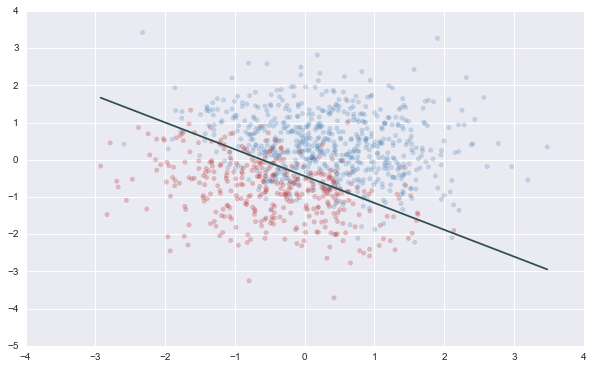

In [34]:
# Actual data
py_random.seed(314)
x_1 = np.random.normal(0, 1, 1000)
x_2 = np.random.standard_normal(1000)
z = 1 + 2 * x_1 + 3 * x_2
pr = 1/(1+np.exp(-z))
y = [1 if py_random.random() < p else 0 for p in pr]
df_x_1 = pd.DataFrame(x_1,columns=["x_1"])
df_x_2 = pd.DataFrame(x_2, columns=["x_2"])
df_y = pd.DataFrame(y, columns=["y"])
df = pd.concat([df_y, df_x_1, df_x_2], axis=1)

result = bootstrap_logm("y ~ x_1 + x_2", data=df)
describe_bootstrap_fit(result)

# Interpreting coefficients
# Keep x_2 the same, increase x_1
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean(x_1) + result["coefficients"][2] * np.mean(x_2))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * (np.mean(x_1) + 1) + result["coefficients"][2] * np.mean(x_2))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_1 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

# Keep x_1 the same, increase x_2
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean(x_1) + result["coefficients"][2] * np.mean(x_2))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * (np.mean(x_1)) + result["coefficients"][2] * (np.mean(x_2) + 1))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_2 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
colors = []
for val in df["y"]:
    if val == 0:
        colors.append( "firebrick")
    else:
        colors.append( "steelblue")

axes.scatter(df["x_1"], df["x_2"], color=colors, alpha=0.25)

xs = np.linspace(df["x_1"].min(), df["x_1"].max(), 100)
b0 = result["coefficients"][ 0]
b1 = result["coefficients"][ 1]
b2 = result["coefficients"][ 2]
ys = -(b1 * xs + b0) / b2

axes.plot( xs, ys, color="darkslategray")

<b>Interpreting coefficients:</b> A 1 unit increase from x_1's mean, increased P(y=1) by about 20%. A 1 unit increase from x_2's mean increased P(y=1) by about 25%. It makes sense that increase is more rapid when x_2 changes since we know it's beta value is greater than x_1's in the original model.

<b>Interpreting bootstrap estimates:</b> None of the confidence intervals include 0 and all the signs are exactly what we expected which means all the terms belong in the model.

**2\.** Because the Logistic Regression is a bit harder, I'm going to only ask you for 3 Experiments but you should follow the same advice as was given for the Linear Regression. Make 3 functions and try to recover them, using the techniques that were discussed in the Module. The more elements you can add, the more twisted you can make the relationships, the better you will be at doing and interpreting *real* data with a *real* logistic regression.

Experiment #1.

**Use the following data and the Bootstrap version of the *Logistic* Regression and recover the coefficients ($\beta$s). Interpret the coefficients, the Bootstrap estimates and plot the Logistic Regression using the XZ-space/decision boundary approach.**

$X_1$ is normally distributed with $\mu=0.0$ and $\sigma=1.0$ (standard normal).

$X_2$ is standard normally distributed.

$z = 1.0 + 2.0 X_1 + 3 X_2 + 5 (X_1 X_2) ^ 2$ 

$p = \frac{1}{1+e^{-z}}$

use p to generate ys as a bernoulli trial.

regression:  y ~ x_1 + x_2 + x_1:x_2
n:  10000
----------
intercept:  1.37835700015 [1.3212176661810187, 1.4291525583697247]
x_1:  0.807238255107 [0.7467934736803784, 0.8370652505670576]
x_2:  1.0804833622 [1.0248131619628582, 1.128513171445818]
x_1:x_2:  0.105943271396 [0.04357123597454782, 0.17605459394788825]
P(y = 1) =  0.798007961853
P(y = 1) = after 1 unit increase to x_1 =  0.898542235817
Difference of  0.100534273964
P(y = 1) =  0.798007961853
P(y = 1) = after 1 unit increase to x_2 =  0.920896646765
Difference of  0.122888684912


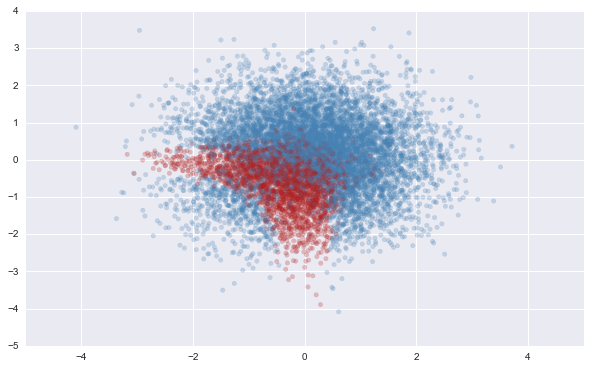

In [55]:
# Actual data
py_random.seed(314)
np.random.seed(314)
x_1 = np.random.normal(0, 1, 10000)
x_2 = np.random.standard_normal(10000)
z = 1 + (2 * x_1) + (3 * x_2) + (5 * ((x_1 * x_2) ** 2))
pr = 1/(1+np.exp(-z))
y = [1 if py_random.random() < p else 0 for p in pr]
df_x_1 = pd.DataFrame(x_1,columns=["x_1"])
df_x_2 = pd.DataFrame(x_2, columns=["x_2"])
df_y = pd.DataFrame(y, columns=["y"])
df = pd.concat([df_y, df_x_1, df_x_2], axis=1)

result = bootstrap_logm("y ~ x_1 + x_2 + x_1:x_2", data=df)
describe_bootstrap_fit(result)

# Interpreting coefficients
# Keep x_2 the same, increase x_1
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean(x_1) + result["coefficients"][2] * np.mean(x_2) + result["coefficients"][3] * (np.mean(x_1 * x_2) ** 2))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * (np.mean(x_1) + 1) + result["coefficients"][2] * np.mean(x_2) + result["coefficients"][3] * ((np.mean(x_1) + 1) * np.mean(x_2)** 2))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_1 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

# Keep x_1 the same, increase x_2
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean(x_1) + result["coefficients"][2] * np.mean(x_2) + result["coefficients"][3] * (np.mean(x_1 * x_2) ** 2))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * (np.mean(x_1)) + result["coefficients"][2] * (np.mean(x_2) + 1) + result["coefficients"][3] * (np.mean(x_1 * (np.mean(x_2) + 1) ** 2)))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_2 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
colors = []
for val in df["y"]:
    if val == 0:
        colors.append( "firebrick")
    else:
        colors.append( "steelblue")

axes.scatter(df["x_1"], df["x_2"], color=colors, alpha=0.25)

I think its fair to say that bootstraping wasn't able to recover the original betas. The estimated betas aren't that close to the originals and the ordinals of the betas (beta_1  < beta_2 < beta_3 < beta_4) isn't preserved.

Interpreting the coefficients: If x_1 is increased by one unit, we expect an increase in the P(Y=1) of about 10\%. If x_2 is increased by one unit, we expect an increase in the P(Y=1) of about 12\%. All the confidence intervals are tight, which would normally give me confidence in the estimate, but I know they are wrong so it doesn't. 

The unit difference tests show that x_2 is more sensitive to a change than x_1, which makes sense because x_2 has a larger coefficient. As far as interpreting the confidence intervals, each interval excludes 0 and is the correct sign, so each variable belongs in the model.

Experiment #2.

**Use the following data and the Bootstrap version of the *Logistic* Regression and recover the coefficients ($\beta$s). Interpret the coefficients, the Bootstrap estimates and plot the Logistic Regression using the XZ-space/decision boundary approach.**

$X_1$ is exponentially distributed with scale = 4.

$X_2$ is exponentially distributed with scale = 2.

$z = 2.0 X_1 + 4.0 X_2$

$p = \frac{1}{1+e^{-z}}$

use p to generate ys as a bernoulli trial.

regression:  y ~ x_1 + x_2
n:  10000
----------
intercept:  0.161527020205 [-0.24325529685007113, 0.5109674857452939]
x_1:  1.94267525227 [1.542199279744596, 2.491272365582062]
x_2:  3.48557624495 [2.9225115288426595, 4.134176382446214]
P(y = 1) =  0.999999638931
P(y = 1) = after 1 unit increase to x_1 =  0.999999948252
Difference of  3.09320438596e-07
P(y = 1) =  0.999999638931
P(y = 1) = after 1 unit increase to x_2 =  0.999999988938
Difference of  3.50007104077e-07


(0, 18)

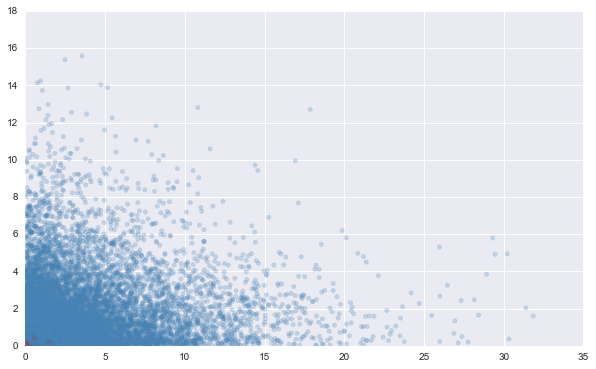

In [56]:
# Actual data
py_random.seed(2345)
np.random.seed(2345)
x_1 = np.random.exponential(4, 10000)
x_2 = np.random.exponential(2, 10000)
z = 2 * x_1 + 4 * x_2
pr = 1/(1+np.exp(-z))
y = [1 if py_random.random() < p else 0 for p in pr]
df_x_1 = pd.DataFrame(x_1,columns=["x_1"])
df_x_2 = pd.DataFrame(x_2, columns=["x_2"])
df_y = pd.DataFrame(y, columns=["y"])
df = pd.concat([df_y, df_x_1, df_x_2], axis=1)

result = bootstrap_logm("y ~ x_1 + x_2", data=df)
describe_bootstrap_fit(result)

# Interpreting coefficients
# Keep x_2 the same, increase x_1
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean(x_1) + result["coefficients"][2] * np.mean(x_2))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * (np.mean(x_1) + 1) + result["coefficients"][2] * np.mean(x_2))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_1 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

# Keep x_1 the same, increase x_2
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean(x_1) + result["coefficients"][2] * np.mean(x_2))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * (np.mean(x_1)) + result["coefficients"][2] * (np.mean(x_2) + 1))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_2 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
colors = []
for val in df["y"]:
    if val == 0:
        colors.append( "firebrick")
    else:
        colors.append( "steelblue")

axes.scatter(df["x_1"], df["x_2"], color=colors, alpha=0.25)
axes.set_xlim((0,35))
axes.set_ylim((0,18))

For this experiment, the coefficients come out much closer to their original values. The only confidence interval that includes zero is the intercept's, which conveys its true value and the fact that it isn't needed in the model. Because x_1 dominates x_2 in spread, the P(y = 1) is nearly 1 everywhere so a unit difference in either isn't noticed in the P(y = 1). As a result, it may be safe to predicte P(y = 1) for every instance instead of using this full blown model.

Interpreting the coefficients: A unit change to each variables mean has little impact on the P(y = 1) since the P(y = 1) is so high to begin with.

Experiment #3.

**Use the following data and the Bootstrap version of the *Logistic* Regression and recover the coefficients ($\beta$s). Interpret the coefficients, the Bootstrap estimates and plot the Logistic Regression using the XZ-space/decision boundary approach.**

$x_1$ is normally distributed with $\mu=0.0$ and $\sigma=1.0$ (standard normal).

$x_2$ is normally distributed with $\mu=10$ and $\sigma=1.0$

$x_3$ is normally distributed with $\mu=20$ and $\sigma=1.0$

$z = 30 (x_1 * x_2 * x_3)^3 + 20 (x_1 * x_2 * x_3)^2 + 10 (x_1 * X_2 * x_3)$ 

$p = \frac{1}{1+e^{-z}}$

use p to generate ys as a bernoulli trial.

regression:  y ~ cube_combo + squared_combo + combo
n:  10000
----------
intercept:  -1.5752800425e-11 [-3.6531892216291454e-10, 2.7185263009454476e-10]
cube_combo:  8.6006537118e-05 [8.059055793233042e-05, 9.223877544252263e-05]
squared_combo:  2.87355206642e-08 [-6.676383144206738e-08, 1.463806429341562e-07]
combo:  1.09984276724e-07 [9.721398780200387e-08, 1.2325214520426e-07]
P(y = 1) =  0.995860274421
P(y = 1) = after 1 unit increase to x_1 =  0.999592272753
Difference of  0.00373199833224
P(y = 1) =  0.995860274421
P(y = 1) = after 1 unit increase to x_2 =  1.0
Difference of  0.0041397255794
P(y = 1) =  0.995860274421
P(y = 1) = after 1 unit increase to x_2 =  0.997548112005
Difference of  0.00168783758398


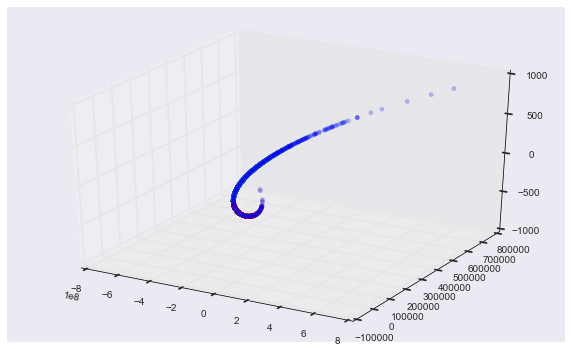

In [50]:
# Actual data
py_random.seed(31400)
np.random.seed(31400)
x_1 = np.random.normal(0, 1, 10000)
x_2 = np.random.normal(10, 1, 10000)
x_3 = np.random.normal(20, 1, 10000)
z = 30 * ((x_1 * x_2 * x_3) ** 3) + 20 * ((x_1 * x_2 * x_3) ** 2) + 10 * (x_1 * x_2 * x_3)
pr = 1/(1+np.exp(-z))
y = [1 if py_random.random() < p else 0 for p in pr]
df_combo_cube = pd.DataFrame((x_1 * x_2 * x_3)**3, columns=["cube_combo"])
df_combo_square = pd.DataFrame((x_1 * x_2 * x_3)**2, columns=["squared_combo"])
df_combo = pd.DataFrame((x_1 * x_2 * x_3), columns=["combo"])
df_y = pd.DataFrame(y, columns=["y"])
df = pd.concat([df_y, df_combo_cube, df_combo_square, df_combo], axis=1)

result = bootstrap_logm("y ~ cube_combo + squared_combo + combo", data=df)
describe_bootstrap_fit(result)

# Interpreting coefficients
# Keep x_1, x_3 the same, increase x_2
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean((x_1 * x_2 * x_3)**3) + result["coefficients"][2] *np.mean((x_1 * x_2 * x_3)**2) + result["coefficients"][3] * np.mean((x_1 * x_2 * x_3)))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean((x_1 * (x_2 + 1) * x_3)**3) + result["coefficients"][2] *np.mean((x_1 * (x_2 + 1) * x_3)**2) + result["coefficients"][3] * np.mean((x_1 * (x_2 + 1) * x_3)))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_1 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

# Keep x_2, x_3 the same, increase x_1
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean((x_1 * x_2 * x_3)**3) + result["coefficients"][2] *np.mean((x_1 * x_2 * x_3)**2) + result["coefficients"][3] * np.mean((x_1 * x_2 * x_3)))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean(((x_1 + 1) * x_2 * x_3)**3) + result["coefficients"][2] *np.mean(((x_1 + 1) * x_2 * x_3)**2) + result["coefficients"][3] * np.mean(((x_1 + 1) * x_2 * x_3)))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_2 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

# Keep x_1, x_2 the same, increase x_3
around_mean = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean((x_1 * x_2 * x_3)**3) + result["coefficients"][2] *np.mean((x_1 * x_2 * x_3)**2) + result["coefficients"][3] * np.mean((x_1 * x_2 * x_3)))
moved_one_unit = logistic(result["coefficients"][0] + result["coefficients"][1] * np.mean((x_1 * x_2 * (x_3 + 1))**3) + result["coefficients"][2] *np.mean((x_1 * x_2 * (x_3 + 1))**2) + result["coefficients"][3] * np.mean((x_1 * x_2 * (x_3 + 1))))
print "P(y = 1) = ", around_mean
print "P(y = 1) = after 1 unit increase to x_2 = ", moved_one_unit
print "Difference of ", moved_one_unit - around_mean

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(111, projection='3d')
colors = []
for val in df["y"]:
    if val == 0:
        colors.append( "firebrick")
    else:
        colors.append( "steelblue")

axes.scatter(df["cube_combo"], df["squared_combo"], df["combo"], color=colors, alpha=0.25)

All things being equal a unit change of their means of x_1, x_2, and x_3 increase P(y = 1) by 0.3\%, 0.4\%, and 0.2\% respectively. The intercept interval contains zero which, in case probably means its safe to discard from the model. A disappointing result of this experiment is that bootstrapping again didn't come close to the original betas. In addtion, in the case of $\beta_{2}$ the wrong sign and zero is included in the confidence interval. My only hypothesis is that logistic regression doesn't do well with higher degree polynomials.